# SherLock

## Load Libraries

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import pickle

In [75]:
pd.set_option('display.max_columns', None)

## Load Data

This will cycle through all the data found in the Kaggle subset data, 'archive'.

### Functions Used

In [2]:
# Functions
def editTextFile(f):
    # Read in the file
    with open(f, 'r') as file:
        filedata = file.read()

    # Replace the target string
    filedata = filedata.replace('[msec],size', '[msec];size')

    # Write the file out again
    with open('editTextFile.txt', 'w') as file:
        file.write(filedata)
        
def magVector(df,col1,col2,col3):
    # Calculate magnitude of vector - SQRT(X^2 + Y^2 + Z^2)
    return ((df[col1].pow(2) + df[col2].pow(2) + df[col3].pow(2)).pow(1/2))        

### Loading

In [3]:
# Non-standard columns present, need function to fix
#filename = './archive/AllBroadcasts.csv'
#AllBroadcasts = pd.read_csv(filename)
#AllBroadcasts['UUID'] = AllBroadcasts['UUID'].apply(pd.to_datetime, unit='ms')

# Drop bad rows for now...
#alphabet_string = string.ascii_lowercase
#alphabet_list = list(alphabet_string)

#AllBroadcasts[AllBroadcasts['timestamp'].str().isin(alphabet_list)]

#indexID = AllBroadcasts[(AllBroadcasts['timestamp'] >= 21)].index
#AllBroadcasts.drop(indexID, inplace = True)


#AllBroadcasts.head(3)

In [4]:
filename = './archive/AppPackages.csv'
AppPackages = pd.read_csv(filename)    # Ending columns need to be appended into sherlock_version - make function!

AppPackages[['UUID','InstallTime']] = AppPackages[['UUID', 'InstallTime']].apply(pd.to_datetime, unit='ms')
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 13'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 14'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 15'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 16'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 17'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 18'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 19'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 20'],sep=",")
#AppPackages.drop([])
#AppPackages = AppPackages.set_index('UUID')
print(AppPackages['UserId'].unique())
AppPackages = AppPackages.drop(columns=['UserId'])
print(AppPackages.shape)
#AppPackages.head(3)

['97bb95f55a']
(298, 20)


In [5]:
filename = './archive/Bluetooth.csv'
Bluetooth = pd.read_csv(filename, parse_dates=['Bluetooth_timestamp'])
Bluetooth = Bluetooth.rename(columns={"UserID": "UUID", "UUID": "UserID"})   # Header names swapped apparently
Bluetooth['UUID'] = Bluetooth['UUID'].apply(pd.to_datetime, unit='ms')
#Bluetooth = Bluetooth.set_index('UUID')
print(Bluetooth['UserID'].unique())
Bluetooth = Bluetooth.drop(columns=['UserID'])
print(Bluetooth.shape)
#Bluetooth.head(3)

['97bb95f55a']
(4398, 10)


In [6]:
filename = './archive/Calls.csv'
Calls = pd.read_csv(filename)
Calls[['UUID','Date']] = Calls[['UUID',
                                'Date']].apply(pd.to_datetime, unit='ms')
Calls['FromContacts'] = Calls['FromContacts'].astype(int)                      # Original True/False
#Calls = Calls.set_index('UUID')
print(Calls['UserId'].unique())
Calls = Calls.drop(columns=['UserId'])
print(Calls.shape)
#Calls.head(3)

['97bb95f55a']
(1748, 6)


In [7]:
# Raw TSV
filename = './Moriartyprobe.tsv'
header_list = ['userid', 'uuid', 'details', 'action', 'actionType', 'sessionType', 'version', 'sessionID', 'behavior']
Moriarty_tsv = pd.read_csv(filename, sep='\t', names=header_list)
Moriarty_tsv['uuid'] = (pd.to_datetime(Moriarty_tsv['uuid'], unit='ms'))     # Convert to datatime
Moriarty_tsv = Moriarty_tsv.sort_values(by='uuid')                           # Unsorted, so sorting required
print(Moriarty_tsv['userid'].unique())
print(Moriarty_tsv.shape)
Moriarty_tsv.head(3)

['fe186dc437' '5b76bedcac' '860550d355' '97bb95f55a' '97dcbc4c4e'
 '0a50e09262' '8ef449026a' '68a5ffab20' 'e0bf6beeb3' '6e200090ee'
 '831b42eaa1' 'ec3b3592f1' '73e9841e35' '1a1a12314b' '6fec24656a'
 'd35184bc22' '56d7a3b146' '55bd790216' 'a4f29791af' '55153967c4'
 'dd25a68e9e' 'abd6f757b8' '9f7c0cf3ba' '3e9c54bce7' 'a582442b42'
 'f68d404dec' '1775bd8416' '8960d74df5' '72edf5f08f' '65f42fb278'
 'fd2db8f0be' 'ffaf2c6521' 'bca57e81a1' 'aa2e99301a' '5c1f751a99'
 '5e9275b594' 'fdbca31c28' '909a83fa62' 'b63c849327' 'cfdf8f8818'
 'e22b9f3772' 'b298fa1895' 'd8d16595c6']
(513981, 9)


,userid,uuid,details,action,actionType,sessionType,version,sessionID,behavior
494619,fe186dc437,2016-01-01 00:14:34.546,Application entered onCreate(),Application started,benign,benign,1.0,27,NaN
494625,fe186dc437,2016-01-01 00:14:34.701,User started to play a game (name);pearl,Game stared,benign,benign,1.0,27,NaN
494620,fe186dc437,2016-01-01 00:14:34.810,App entered onResume,App Mode change,benign,benign,1.0,27,NaN


In [8]:
# drop odd states
print(Moriarty_tsv['actionType'].unique())
print(Moriarty_tsv[Moriarty_tsv['actionType'] == 'html'].shape)
print(Moriarty_tsv[Moriarty_tsv['actionType'] == 'javascript'].shape)

Moriarty_tsv = Moriarty_tsv.drop(Moriarty_tsv[(Moriarty_tsv['actionType'] == 'html') | 
                                              (Moriarty_tsv['actionType'] == 'javascript')].index)
Moriarty_tsv.shape

['benign' 'malicious' 'html' 'javascript']
(49, 9)
(31, 9)


(513901, 9)

In [9]:
# Kaggle CSV
filename = './archive/Moriarty.csv'
editTextFile(filename)
Moriarty = pd.read_csv('editTextFile.txt')
Moriarty['UUID'] = (pd.to_datetime(Moriarty['UUID'], unit='ms'))
#Moriarty = Moriarty.set_index('UUID')
print(Moriarty['UserId'].unique())
Moriarty = Moriarty.drop(columns=['UserId'])
print(Moriarty.shape)
#Moriarty.head(3)

['97bb95f55a']
(186, 7)


In [10]:
# Raw TSV
filename = './Screenon.tsv'
header_list = ['userid', 'uuid', 'screenon', 'timestamp']
Screenon_tsv = pd.read_csv(filename, sep='\t', names=header_list, parse_dates=['timestamp'])
Screenon_tsv['uuid'] = (pd.to_datetime(Screenon_tsv['uuid'], unit='ms'))
Screenon_tsv = Screenon_tsv.sort_values(by='uuid')
Screenon_tsv['screenon'] = Screenon_tsv['screenon'].astype(int)                    # Original True:On / False:Off
print(Screenon_tsv['userid'].unique())
print(Screenon_tsv.shape)
Screenon_tsv.head()

['5b76bedcac' '0a50e09262' '65f42fb278' 'dd25a68e9e' '55153967c4'
 '6e200090ee' 'fe186dc437' 'abd6f757b8' '9c75d26567' '860550d355'
 '831b42eaa1' '55bd790216' 'e0bf6beeb3' '73e9841e35' '9f7c0cf3ba'
 '68a5ffab20' 'ec3b3592f1' '1a1a12314b' 'd35184bc22' '8ef449026a'
 '56d7a3b146' '97bb95f55a' '97dcbc4c4e' '6fec24656a' 'a4f29791af'
 'a582442b42' '3e9c54bce7' 'e306e8a7c9' 'f68d404dec' '1775bd8416'
 '8960d74df5' '909a83fa62' '72edf5f08f' '5c1f751a99' 'fd2db8f0be'
 'ffaf2c6521' 'aa2e99301a' 'bca57e81a1' '5e9275b594' 'fdbca31c28'
 'e22b9f3772' 'b63c849327' 'd8d16595c6' '2cd992fd5e' 'b298fa1895'
 'cfdf8f8818' '688dccef72']
(617639, 4)


,userid,uuid,screenon,timestamp
136056,5b76bedcac,2016-01-01 00:01:59.446,1,2016-01-01 02:01:59.445
0,0a50e09262,2016-01-01 00:01:59.475,1,2016-01-01 02:01:59.474
170911,65f42fb278,2016-01-01 00:02:01.760,1,2016-01-01 02:02:01.759
136057,5b76bedcac,2016-01-01 00:02:21.323,0,2016-01-01 02:02:21.323
1,0a50e09262,2016-01-01 00:02:29.340,0,2016-01-01 02:02:29.340


In [11]:
# Kaggle CSV
filename = './archive/ScreenOn.csv'
ScreenOn = pd.read_csv(filename, parse_dates=['Timestamp'])
ScreenOn['UUID'] = (pd.to_datetime(ScreenOn['UUID'], unit='ms'))
ScreenOn['ScreenOn'] = ScreenOn['ScreenOn'].astype(int)                    # Original True/False
#ScreenOn = ScreenOn.set_index('UUID')
print(ScreenOn['UserID'].unique())
ScreenOn = ScreenOn.drop(columns=['UserID'])
print(ScreenOn.shape)
#ScreenOn.head(3)

['97bb95f55a']
(1929, 3)


In [12]:
filename = './archive/SMS.csv'
SMS = pd.read_csv(filename)
SMS[['UUID','Date']] = SMS[['UUID','Date']].apply(pd.to_datetime, unit='ms')
SMS[['ContainsURL', 'FromContacts']] = SMS[['ContainsURL', 
                                            'FromContacts']].astype(int)   # Original True/False
#SMS = SMS.set_index('UUID')
print(SMS['UserId'].unique())
SMS = SMS.drop(columns=['UserId'])
print(SMS.shape)
#SMS.head(3)

['97bb95f55a']
(605, 6)


In [13]:
filename = './archive/T0.csv'
T0 = pd.read_csv(filename, parse_dates=['Telephoney_timestemp', 
                                        'SystemInfo_timestemp'])
T0['UUID'] = (pd.to_datetime(T0['UUID'], unit='ms'))
#T0 = T0.set_index('UUID')
print(T0['UserId'].unique())
T0 = T0.drop(columns=['UserId'])
print(T0.shape)
#T0.head(3)

['97bb95f55a']
(42, 28)


In [91]:
# Raw TSV
filename = './a_anon_T1.tsv'
header_list = ['userid', 'uuid', 'version', 'googleplayloc_speed','googleplayloc_maccuracy',
               'googleplayloc_timestamp','celltower_cid','celltower_lac','celltower_psc',
               'celltower_timestamp','celltower_type','status_alarmvol','status_brightnessmode',
               'status_brightness_file','status_brightness_settings','status_dtmfvol','status_musicvol',
               'status_notificationvol','status_orientation','status_ringermode','status_ringtonevol',
               'status_systemvol','status_voicecallvol','status_timestamp',
               'location_spatio_5means','location_spatio_10means','location_spatio_25means',
               'location_spatio_50means','location_spatio_75means','location_spatio_100means',
               'location_spatioTemporal_day_5means','location_spatioTemporal_day_25means',
               'location_spatioTemporal_day_100means','location_spatioTemporal_week_5means',
               'location_spatioTemporal_week_25means','location_spatioTemporal_week_100means']
T1_tsv = pd.read_csv(filename, sep='\t', names=header_list, parse_dates=['googleplayloc_timestamp',
                                                                        'celltower_timestamp',
                                                                        'status_timestamp'])
T1_tsv['uuid'] = (pd.to_datetime(T1_tsv['uuid'], unit='ms'))
T1_tsv = T1_tsv.sort_values(by='uuid')
#print(T1_tsv['userid'].unique())
print(T1_tsv.shape)
T1_tsv.head(3)

/Users/kent/opt/anaconda3/envs/sherlock/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(2697136, 36)


,userid,uuid,version,googleplayloc_speed,googleplayloc_maccuracy,googleplayloc_timestamp,celltower_cid,celltower_lac,celltower_psc,celltower_timestamp,celltower_type,status_alarmvol,status_brightnessmode,status_brightness_file,status_brightness_settings,status_dtmfvol,status_musicvol,status_notificationvol,status_orientation,status_ringermode,status_ringtonevol,status_systemvol,status_voicecallvol,status_timestamp,location_spatio_5means,location_spatio_10means,location_spatio_25means,location_spatio_50means,location_spatio_75means,location_spatio_100means,location_spatioTemporal_day_5means,location_spatioTemporal_day_25means,location_spatioTemporal_day_100means,location_spatioTemporal_week_5means,location_spatioTemporal_week_25means,location_spatioTemporal_week_100means
1243201,8ef449026a,2016-01-01 00:00:13.068000000,2.0,0.0,39.0,2016-01-01 02:00:02.205,6e6ed5bf6b41f5f,7e347f4c49a684c,bd10d7619b5800a,2016-01-01 02:00:00.180,1.0,11.0,Manual,0.0,20.0,15.0,6.0,15.0,Portrait,Normal,15.0,12.0,4.0,2016-01-01 02:00:00.168,5.0,2.0,1.0,25.0,70.0,78.0,3.0,4.0,25.0,1.0,7.0,53.0
1530201,9f7c0cf3ba,2016-01-01 00:00:13.704000000,2.0,0.0,34.5,2016-01-01 02:00:02.717,af02e3b2c73b03f,a7d0f5ff55a6956,0fe710c81ab2c69,2016-01-01 02:00:00.810,1.0,11.0,Auto,0.0,134.0,0.0,7.0,0.0,Portrait,Normal,0.0,0.0,5.0,2016-01-01 02:00:00.889,2.0,2.0,1.0,34.0,56.0,81.0,3.0,9.0,60.0,1.0,10.0,75.0
2144995,dd25a68e9e,2016-01-01 00:00:13.838000128,2.0,0.0,40.5,2016-01-01 01:59:36.848,90c38b44e42dfce,2c482b578dd5ef9,6bd33b4b0e8172b,2016-01-01 01:59:33.820,1.0,11.0,Manual,0.0,101.0,0.0,15.0,0.0,Portrait,Normal,0.0,0.0,5.0,2016-01-01 01:59:33.825,3.0,5.0,9.0,50.0,14.0,21.0,5.0,2.0,40.0,5.0,8.0,96.0


In [14]:
# CSV
filename = './archive/T1.csv'
T1 = pd.read_csv(filename, parse_dates=['GooglePlayLoc_timestamp', 
                                        'CellTower_timestamp', 
                                        'Status_timestamp'])
T1['UUID'] = (pd.to_datetime(T1['UUID'], unit='ms'))
#T1 = T1.set_index('UUID')
print(T1['UserID'].unique())
T1 = T1.drop(columns=['UserID'])
print(T1.shape)
#T1.head(3)

['97bb95f55a']
(24762, 35)


In [15]:
filename = './archive/T2.csv'
T2 = pd.read_csv(filename, parse_dates=['TimeStemp'], low_memory=False)
T2['UUID'] = (pd.to_datetime(T2['UUID'], unit='ms'))
#T2 = T2.set_index('UUID')
print(T2['UserID'].unique())
T2 = T2.drop(columns=['UserID'])
print(T2.shape)
#T2.head(3)

['97bb95f55a']
(78646, 244)


In [16]:
filename = './archive/T3.csv'
T3 = pd.read_csv(filename, parse_dates=['Audio_timestemp', 
                                        'Light_timestamp'], low_memory=False)
T3['UUID'] = (pd.to_datetime(T3['UUID'], unit='ms'))
#T3 = T3.set_index('UUID')
#print(T3['Userid'].unique())
T3 = T3.drop(columns=['Userid'])
print(T3.shape)
#3.head(3)

(144822, 26)


In [17]:
filename = './archive/T4.csv'
T4 = pd.read_csv(filename, parse_dates=['Traffic_timestamp', 
                                        'Battery_timestamp'], low_memory=False)
T4['UUID'] = (pd.to_datetime(T4['UUID'], unit='ms'))
T4['btime'] = (pd.to_datetime(T4['btime'], unit='s'))
#T4 = T4.set_index('UUID')
print(T4['Userid'].unique())
T4 = T4.drop(columns=['Userid'])
print(T4.shape)
#T4.head(3)

['97bb95f55a']
(156017, 115)


In [66]:
# Raw TSV
filename = './Userpresentprobe.tsv'
header_list = ['userid', 'uuid', 'timestamp']
Userpresentprobe_tsv = pd.read_csv(filename, sep='\t', names=header_list, parse_dates=['timestamp'])
Userpresentprobe_tsv['uuid'] = (pd.to_datetime(Userpresentprobe_tsv['uuid'], unit='ms'))
Userpresentprobe_tsv = Userpresentprobe_tsv.sort_values(by='uuid')
Userpresentprobe_tsv['UP_status'] = 1
print(Userpresentprobe_tsv['userid'].unique())
print(Userpresentprobe_tsv.shape)
Userpresentprobe_tsv.head()

['5b76bedcac' '65f42fb278' 'dd25a68e9e' '6e200090ee' 'fe186dc437'
 '860550d355' '73e9841e35' '9f7c0cf3ba' '1a1a12314b' 'ec3b3592f1'
 '68a5ffab20' 'abd6f757b8' 'd35184bc22' '55bd790216' '0a50e09262'
 '9c75d26567' '8ef449026a' '56d7a3b146' '97bb95f55a' 'e0bf6beeb3'
 '55153967c4' '831b42eaa1' '97dcbc4c4e' '6fec24656a' 'a4f29791af'
 'a582442b42' '3e9c54bce7' 'e306e8a7c9' 'f68d404dec' '1775bd8416'
 '8960d74df5' '909a83fa62' '72edf5f08f' '5c1f751a99' 'fd2db8f0be'
 'ffaf2c6521' 'aa2e99301a' 'bca57e81a1' '5e9275b594' 'fdbca31c28'
 'e22b9f3772' 'b63c849327' 'd8d16595c6' '2cd992fd5e' 'b298fa1895'
 'cfdf8f8818' '688dccef72']
(169313, 4)


,userid,uuid,timestamp,UP_status
33683,5b76bedcac,2016-01-01 00:02:03.374,2016-01-01 02:02:03.372,1
42423,65f42fb278,2016-01-01 00:02:07.033,2016-01-01 02:02:07.027,1
33685,5b76bedcac,2016-01-01 00:08:44.234,2016-01-01 02:08:44.226,1
134431,dd25a68e9e,2016-01-01 00:10:26.500,2016-01-01 02:10:26.496,1
52031,6e200090ee,2016-01-01 00:14:26.650,2016-01-01 02:14:26.645,1


In [19]:
# Kaggle CSV
filename = './archive/UserPresent.csv'
UserPresent = pd.read_csv(filename, parse_dates=['timestamp'])
UserPresent['UUID'] = (pd.to_datetime(UserPresent['UUID'], unit='ms'))
#UserPresent = UserPresent.set_index('UUID')
print(UserPresent['userID'].unique())
UserPresent = UserPresent.drop(columns=['userID'])
print(UserPresent.shape)
#UserPresent.head(3)

['97bb95f55a']
(467, 2)


In [20]:
filename = './archive/Wifi.csv'
Wifi = pd.read_csv(filename)
Wifi['UUID'] = (pd.to_datetime(Wifi['UUID'], unit='ms'))
#Wifi = Wifi.set_index('UUID')
print(Wifi['UserID'].unique())
Wifi = Wifi.drop(columns=['UserID'])
print(Wifi.shape)
#Wifi.head(3)

['97bb95f55a']
(110477, 5)


## EDA

#### Moriarty exploration

In [21]:
# TSV
print('Moriarty Sessions: ', Moriarty_tsv.sessionType.count())
print(Moriarty_tsv.groupby('sessionType')['uuid'].nunique())
Moriarty_tsv.groupby('actionType')['uuid'].nunique()
# should drop the non-benign/malicious....

Moriarty Sessions:  513901
sessionType
benign        55337
malicious    446959
Name: uuid, dtype: int64


actionType
benign         9761
malicious    492525
Name: uuid, dtype: int64

In [22]:
# CSV
print('Moriarty Sessions: ', Moriarty.SessionType.count())
#Moriarty.groupby('SessionType')['UUID'].nunique()
#Moriarty.groupby('ActionType')['UUID'].nunique()

Moriarty Sessions:  186


In [23]:
# TSV
Moriarty_tsv['sessionID'].value_counts()
#Moriarty_tsv['sessionID'].unique()
#Moriarty_tsv.groupby(['sessionID', 'sessionType']).count()

15      134590
0        50032
3        33974
17       30191
5        29383
         ...  
1013         5
2009         4
1017         4
1003         3
2001         2
Name: sessionID, Length: 64, dtype: int64

In [24]:
# CSV
Moriarty['SessionID'].value_counts()
#Moriarty['SessionID'].unique()
#Moriarty.groupby(['SessionID', 'SessionType']).count()

10    68
12    29
8     26
11    17
9     14
6     12
5     11
3      4
4      4
0      1
Name: SessionID, dtype: int64

In [25]:
# TSV
pd.set_option('display.max_rows', 1000)
Moriarty_tsv.head(500)

,userid,uuid,details,action,actionType,sessionType,version,sessionID,behavior
494619,fe186dc437,2016-01-01 00:14:34.546,Application entered onCreate(),Application started,benign,benign,1.0,27,NaN
494625,fe186dc437,2016-01-01 00:14:34.701,User started to play a game (name);pearl,Game stared,benign,benign,1.0,27,NaN
494620,fe186dc437,2016-01-01 00:14:34.810,App entered onResume,App Mode change,benign,benign,1.0,27,NaN
494618,fe186dc437,2016-01-01 00:14:40.792,App entered onPause(),App Mode change,benign,benign,1.0,27,NaN
494622,fe186dc437,2016-01-01 00:14:41.996,User exited from game (name);pearl,Game end,benign,benign,1.0,27,NaN
494627,fe186dc437,2016-01-01 00:14:50.657,User chosen to play a game (name);net,Game start,benign,benign,1.0,27,NaN
494621,fe186dc437,2016-01-01 00:14:50.709,User started to play a game (name);net,Game stared,benign,benign,1.0,27,NaN
494626,fe186dc437,2016-01-01 00:14:50.810,App entered onResume,App Mode change,benign,benign,1.0,27,NaN
84892,5b76bedcac,2016-01-01 00:16:33.234,Application entered onCreate(),Application started,benign,malicious,1.0,11,NaN
84866,5b76bedcac,2016-01-01 00:16:33.237,starting Moriarty's intent service,Moriarty start,malicious,malicious,1.0,11,NaN


In [26]:
# CSV
#pd.set_option('display.max_rows', 500)
Moriarty

In [27]:
pd.set_option('display.max_rows', 15)

Benign actions

In [28]:
Moriarty[Moriarty["ActionType"] == "benign"][["Details", "Action"]]

,Details,Action
9,App Entered onCreate(),App Mode Change
10,App entered onResume(),App Mode Change
20,App Entered onCreate(),App Mode Change
21,App entered onResume(),App Mode Change
22,App entered onPause(),App Mode Change
...,...,...
163,Entered to Game view,View Change
164,Entered to Game view,View Change
165,Entered to Game view,View Change
166,Entered to Game view,View Change


Malicious

In [29]:
Moriarty[Moriarty["ActionType"] == "malicious"][["Details", "Action"]]

,Details,Action
0,Added shortcut to the home screen(app);skype,Add Shortcut
1,Login screen launched(login app);Skype,Shortcut Tapped
2,App Entered onCreate(),App Mode Change
3,App entered onResume(),App Mode Change
4,Begin: Sending Password to server,Sending Data
...,...,...
181,App entered onPause(),App Mode Change
182,Successful send to server(duration [msec];size...,Sending Data
183,Begin: Sending Password to server,Sending Data
184,Successful send to server(duration [msec];size...,Sending Data


In [52]:
# TSV 
mSessList = Moriarty_tsv['sessionID'].unique()
minT = []
maxT = []

for i, ses in enumerate(mSessList):
    x = Moriarty_tsv[Moriarty_tsv['sessionID'] == ses]['uuid'].min()
    y = Moriarty_tsv[Moriarty_tsv['sessionID'] == ses]['uuid'].max()
    minT.append(x)
    maxT.append(y)

MoriartySessions = pd.concat([pd.Series(mSessList,name='sessionID'),
                              pd.Series(minT,name='minT'),
                              pd.Series(maxT,name='maxT')], axis=1)
MoriartySessions['Duration'] = MoriartySessions['maxT'] - MoriartySessions['minT']
MoriartySessions

,sessionID,minT,maxT,Duration
0,27,2016-01-01 00:14:34.546,2016-03-31 01:00:03.745,90 days 00:45:29.199000
1,11,2016-01-01 00:16:33.234,2016-03-27 08:52:22.110,86 days 08:35:48.876000
2,29,2016-01-01 05:25:49.814,2016-03-30 08:57:02.238,89 days 03:31:12.424000
3,5,2016-01-01 06:28:29.404,2016-03-15 00:13:17.452,73 days 17:44:48.048000
4,21,2016-01-01 08:03:00.316,2016-03-31 14:54:24.855,90 days 06:51:24.539000
5,9,2016-01-01 12:52:20.783,2016-03-22 09:58:49.378,80 days 21:06:28.595000
6,13,2016-01-02 17:02:35.464,2016-03-30 08:09:12.256,87 days 15:06:36.792000
7,22,2016-01-02 17:39:30.198,2016-03-30 04:29:09.052,87 days 10:49:38.854000
8,4,2016-01-02 20:06:48.054,2016-03-20 07:00:44.373,77 days 10:53:56.319000
9,6,2016-01-02 21:29:57.721,2016-03-28 02:59:22.651,85 days 05:29:24.930000


In [30]:
# CSV 

mSessList = Moriarty['SessionID'].unique()
minT = []
maxT = []

for i, ses in enumerate(mSessList):
    x = Moriarty[Moriarty['SessionID'] == ses]['UUID'].min()
    y = Moriarty[Moriarty['SessionID'] == ses]['UUID'].max()
    minT.append(x)
    maxT.append(y)

MoriartySessions = pd.concat([pd.Series(mSessList,name='SessionID'),
                              pd.Series(minT,name='minT'),
                              pd.Series(maxT,name='maxT')], axis=1)
MoriartySessions['Duration'] = MoriartySessions['maxT'] - MoriartySessions['minT']
MoriartySessions

,SessionID,minT,maxT,Duration
0,0,2016-04-28 13:56:55.453,2016-04-28 13:56:55.453,0 days 00:00:00
1,3,2016-05-01 05:35:20.285,2016-05-01 05:35:39.256,0 days 00:00:18.971000
2,4,2016-05-01 10:20:35.506,2016-05-01 10:20:49.661,0 days 00:00:14.155000
3,5,2016-05-01 12:25:10.549,2016-05-03 19:20:29.641,2 days 06:55:19.092000
4,6,2016-05-03 19:20:46.068,2016-05-03 19:25:23.237,0 days 00:04:37.169000
5,8,2016-05-08 04:06:47.956,2016-05-08 05:50:28.485,0 days 01:43:40.529000
6,9,2016-05-11 22:33:16.789,2016-05-12 18:44:54.182,0 days 20:11:37.393000
7,10,2016-05-14 19:10:50.904,2016-05-17 10:14:09.707,2 days 15:03:18.803000
8,11,2016-05-17 17:57:43.255,2016-05-18 05:27:00.070,0 days 11:29:16.815000
9,12,2016-05-18 09:53:06.705,2016-05-18 09:59:56.193,0 days 00:06:49.488000


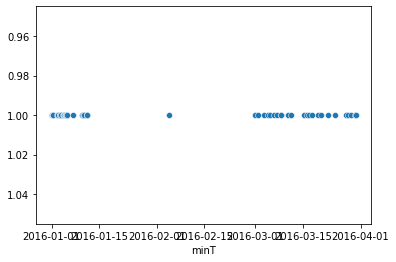

In [53]:
# TSV time series plots of moriarty
sns.scatterplot(data=MoriartySessions, x='minT', y=1)
plt.gca().invert_yaxis()
plt.show()

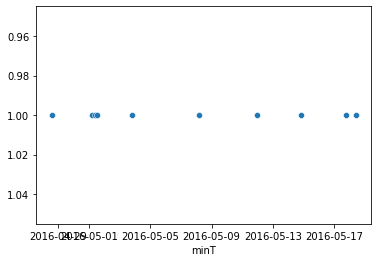

In [31]:
# CSV time series plots of moriarty
sns.scatterplot(data=MoriartySessions, x='minT', y=1)
plt.gca().invert_yaxis()
plt.show()

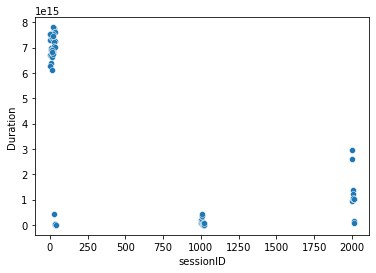

In [68]:
# TSV duration of moriarty
sns.scatterplot(data=MoriartySessions, x='sessionID', y='Duration')
plt.gca().invert_yaxis()
plt.show()
# need to find different x axis, time

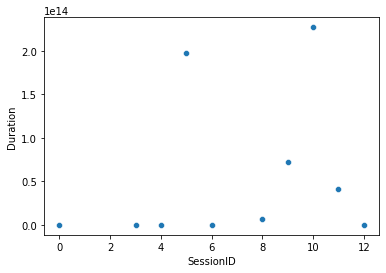

In [32]:
# CSV duration of moriarty
sns.scatterplot(data=MoriartySessions, x='SessionID', y='Duration')
plt.gca().invert_yaxis()
plt.show()

In [33]:
# plot intra-session moriarty behavorior

## Feature engineering of Moriarty

In [61]:
# TSV
binary = {'benign': 0, 'malicious': 1}
Moriarty_tsv = Moriarty_tsv.replace({'actionType':binary})
Moriarty_tsv = Moriarty_tsv.replace({'sessionType':binary})
Moriarty_tsv

,userid,uuid,details,action,actionType,sessionType,version,sessionID,behavior
494619,fe186dc437,2016-01-01 00:14:34.546,Application entered onCreate(),Application started,0,0,1.0,27,NaN
494625,fe186dc437,2016-01-01 00:14:34.701,User started to play a game (name);pearl,Game stared,0,0,1.0,27,NaN
494620,fe186dc437,2016-01-01 00:14:34.810,App entered onResume,App Mode change,0,0,1.0,27,NaN
494618,fe186dc437,2016-01-01 00:14:40.792,App entered onPause(),App Mode change,0,0,1.0,27,NaN
494622,fe186dc437,2016-01-01 00:14:41.996,User exited from game (name);pearl,Game end,0,0,1.0,27,NaN
...,...,...,...,...,...,...,...,...,...
84849,56d7a3b146,2016-03-31 21:10:41.323,Searching for new photos to steal from the gal...,Reading File(s),1,1,3.0,2000,NaN
84851,56d7a3b146,2016-03-31 21:10:41.324,Didn't found a new photo(actor);Active-Thief,Reading File(s),1,1,3.0,2000,NaN
84839,56d7a3b146,2016-03-31 21:11:04.602,searching for wifi,Probing for WiFi access,1,1,3.0,2000,NaN
84834,56d7a3b146,2016-03-31 21:11:23.881,searching for wifi,Probing for WiFi access,1,1,3.0,2000,NaN


In [34]:
# CSV
binary = {'benign': 0, 'malicious': 1}
Moriarty = Moriarty.replace({'ActionType':binary})
Moriarty = Moriarty.replace({'SessionType':binary})
Moriarty

,UUID,Details,Action,ActionType,SessionType,Version,SessionID
0,2016-04-28 13:56:55.453,Added shortcut to the home screen(app);skype,Add Shortcut,1,1,5.0,0
1,2016-05-01 05:35:20.285,Login screen launched(login app);Skype,Shortcut Tapped,1,1,5.0,3
2,2016-05-01 05:35:20.288,App Entered onCreate(),App Mode Change,1,1,5.0,3
3,2016-05-01 05:35:20.378,App entered onResume(),App Mode Change,1,1,5.0,3
4,2016-05-01 05:35:39.256,Begin: Sending Password to server,Sending Data,1,1,5.0,3
...,...,...,...,...,...,...,...
181,2016-05-18 09:59:50.825,App entered onPause(),App Mode Change,1,1,5.0,12
182,2016-05-18 09:59:51.466,Successful send to server(duration [msec];size...,Sending Data,1,1,5.0,12
183,2016-05-18 09:59:51.784,Begin: Sending Password to server,Sending Data,1,1,5.0,12
184,2016-05-18 09:59:52.387,Successful send to server(duration [msec];size...,Sending Data,1,1,5.0,12


### Sensors

In [35]:
T2['magAccel'] = magVector(T2,'AccelerometerStat_x_MIDDLE_SAMPLE',
                           'AccelerometerStat_y_MIDDLE_SAMPLE',
                           'AccelerometerStat_z_MIDDLE_SAMPLE')
T2['magMag'] = magVector(T2,'MagneticField_x_MIDDLE_SAMPLE',
                           'MagneticField_y_MIDDLE_SAMPLE',
                           'MagneticField_z_MIDDLE_SAMPLE')
    
T2.head(3)

,UUID,Version,TimeStemp,AccelerometerStat_x_DC_FFT,AccelerometerStat_x_FIRST_IDX_FFT,AccelerometerStat_x_FIRST_VAL_FFT,AccelerometerStat_x_FOURTH_IDX_FFT,AccelerometerStat_x_FOURTH_VAL_FFT,AccelerometerStat_x_MEAN,AccelerometerStat_x_MEAN_FFT,...,AccelerometerStat_z_MIDDLE_SAMPLE,GyroscopeStat_x_MIDDLE_SAMPLE,GyroscopeStat_y_MIDDLE_SAMPLE,GyroscopeStat_z_MIDDLE_SAMPLE,MagneticField_x_MIDDLE_SAMPLE,MagneticField_y_MIDDLE_SAMPLE,MagneticField_z_MIDDLE_SAMPLE,pressure_MIDDLE_SAMPLE,magAccel,magMag
0,2016-04-27 21:32:55.659,2.2,2016-04-28 00:32:55.659,112.709439,256.0,0.070102,254.0,0.079229,-0.557968,1.566997,...,8.746617,-0.010386,-0.007457,-0.007191,-21.90,-9.06,-36.78,991.6177,8.860996,43.754565
1,2016-04-27 21:33:15.462,2.2,2016-04-28 00:33:15.462,14.500483,256.0,0.010774,232.0,0.168699,-0.074745,1.960746,...,8.868722,-0.011185,-0.008522,-0.007723,-22.74,-7.92,-37.86,991.6001,8.886932,44.868849
2,2016-04-27 21:33:35.793,2.2,2016-04-28 00:33:35.793,52.429426,256.0,0.021820,254.0,0.042375,-0.268869,0.786337,...,8.807071,-0.009854,-0.007723,-0.008256,-22.32,-9.54,-36.84,991.6167,8.872734,44.117792


In [36]:
# plots of sensors in time...

## Extract Moriarty across datasets

In [73]:
# TSV
print(Moriarty_tsv.shape)
print(Screenon_tsv.shape)
print(Userpresentprobe_tsv.shape)


print(pd.merge(left=Moriarty_tsv, right=Screenon_tsv, left_on='uuid', right_on='uuid').shape)
print(pd.merge(left=Moriarty_tsv, right=Userpresentprobe_tsv, left_on='uuid', right_on='uuid').shape)

#merged_left = pd.merge(left=Moriarty_tsv, right=Screenon_tsv, how='left', left_on='uuid', right_on='uuid')
#merged_left.tail(200)

(513901, 9)
(617639, 4)
(169313, 4)
(50, 12)
(11, 12)


### Screen On

In [37]:
#Moriarty = Moriarty.set_index('UUID')
#ScreenOn = ScreenOn.set_index('UUID')

Merged = ScreenOn.append(Moriarty, sort=True)
#Merged = Merged.sort_index()
Merged = Merged.sort_values(by='UUID')

Merged['ScreenOn'] = Merged['ScreenOn'].fillna(method="pad")
pd.set_option('display.max_rows', 500)
Merged

,Action,ActionType,Details,ScreenOn,SessionID,SessionType,Timestamp,UUID,Version
0,NaN,NaN,NaN,1.0,NaN,NaN,2016-04-28 02:21:44.991,2016-04-27 23:21:44.991,NaN
1,NaN,NaN,NaN,0.0,NaN,NaN,2016-04-28 02:22:50.982,2016-04-27 23:22:50.983,NaN
2,NaN,NaN,NaN,1.0,NaN,NaN,2016-04-28 02:25:35.929,2016-04-27 23:25:35.929,NaN
3,NaN,NaN,NaN,0.0,NaN,NaN,2016-04-28 02:25:47.083,2016-04-27 23:25:47.083,NaN
4,NaN,NaN,NaN,1.0,NaN,NaN,2016-04-28 02:25:58.975,2016-04-27 23:25:58.976,NaN
...,...,...,...,...,...,...,...,...,...
1924,NaN,NaN,NaN,0.0,NaN,NaN,2016-05-18 23:35:51.390,2016-05-18 20:35:51.391,NaN
1925,NaN,NaN,NaN,1.0,NaN,NaN,2016-05-19 00:35:42.867,2016-05-18 21:35:42.868,NaN
1926,NaN,NaN,NaN,0.0,NaN,NaN,2016-05-19 00:35:52.652,2016-05-18 21:35:52.652,NaN
1927,NaN,NaN,NaN,1.0,NaN,NaN,2016-05-19 00:36:06.226,2016-05-18 21:36:06.226,NaN


In [38]:
filteredMerged = pd.DataFrame()

for index, row in MoriartySessions.iterrows():
    data = Merged[(Merged['UUID'] > row['minT']) & (Merged['UUID'] < row['maxT'])]
    filteredMerged = filteredMerged.append(data, ignore_index=True)
    
filteredMerged[['SessionID', 'SessionType', 'Version']] = filteredMerged[['SessionID', 'SessionType', 'Version']].fillna(method="pad")

In [39]:
# next steps - integer encode unique - aggregate Success...
filteredMerged['Details'].unique()

array(['App Entered onCreate()', 'App entered onResume()', nan,
       'Login screen launched(login app);Facebook',
       'Begin: Sending Password to server', 'App entered onPause()',
       'Successful send to server(duration [msec];size [bytes]);410;30',
       'App entered onStop()', 'Entered to Level view',
       'Entered to Game view',
       'Successful send to server(duration [msec];size [bytes]);271;30',
       'App entered onDestroy()', 'Pop Notification(app);skype',
       'Added shortcut to the home screen(app);skype',
       'Login screen launched(login app);Skype',
       'Successful send to server(duration [msec];size [bytes]);761;27',
       'Successful send to server(duration [msec];size [bytes]);324;30',
       'Successful send to server(duration [msec];size [bytes]);910;30',
       'Successful send to server(duration [msec];size [bytes]);239;30',
       'Successful send to server(duration [msec];size [bytes]);227;27',
       'Successful send to server(duration [msec

In [40]:
#unit type action type
#malicious vs benigin

In [41]:
###### predict is screen on from magnitude

In [42]:
#### predict screen on moriarty...

/Users/kent/opt/anaconda3/envs/sherlock/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


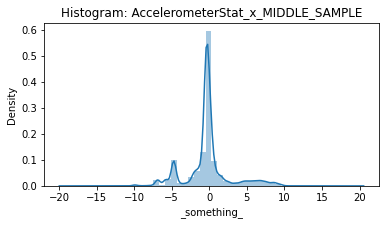

In [43]:
sns.distplot(T2['AccelerometerStat_x_MIDDLE_SAMPLE'])
plt.title('Histogram: AccelerometerStat_x_MIDDLE_SAMPLE')
plt.xlabel('_something_')
f = plt.gcf()
f.set_size_inches(6,3)
plt.show()

### Goofy stuff

In [44]:
t2_accelero = T2[['AccelerometerStat_x_MIDDLE_SAMPLE', 
                  'AccelerometerStat_y_MIDDLE_SAMPLE', 
                  'AccelerometerStat_z_MIDDLE_SAMPLE',
                  'pressure_MIDDLE_SAMPLE']]

t2_accelero.isnull().values.any()
t2_accelero = t2_accelero.dropna()
t2_accelero.isnull().values.any()

t2_accelero_X = t2_accelero[['AccelerometerStat_x_MIDDLE_SAMPLE', 
                  'AccelerometerStat_y_MIDDLE_SAMPLE', 
                  'AccelerometerStat_z_MIDDLE_SAMPLE']]
t2_accelero_y = t2_accelero[['pressure_MIDDLE_SAMPLE']]

X_train, X_test, y_train, y_test = train_test_split(t2_accelero_X, t2_accelero_y, random_state=42)

### Pipeline for pipeline assignment

In [45]:
pipe = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.050263237819209716

Pretty poor, eh?  Well, what would you expect from a random grab...

### Pickle the model

In [46]:
with open('model.pkl', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(pipe, f, pickle.HIGHEST_PROTOCOL)

### Create faux-data

In [47]:
print(X_test[0:2].values.tolist())

[[-0.38845924, 0.36272156, 8.802282], [2.2254105, -1.0384849, 8.515577]]


In [48]:
#Export as json
import json

data = X_test[0:2].values.tolist()

with open('testdata.json', 'w') as f:
    json.dump(data, f)

### Tests

In [49]:
from newdata import newdata
newdata

[[-0.38845924, 0.36272156, 8.802282], [2.2254105, -1.0384849, 8.515577]]

In [50]:
with open('model.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    pipePKL = pickle.load(f)

In [51]:
predictions = pipePKL.predict(newdata)
print(predictions)

[[970.48399837]
 [968.49615397]]
